In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import xarray as xr
import os
import sys                                              
import glob
import datetime

In [2]:
%%time
stations = pd.read_excel('/g/data/w28/yk8692/nesp_backup/station/All_stations_information.xlsx')
file_path = '/g/data/w28/yk8692/nesp_backup'
region_name = "Greater Darwin"
region_name_full = "Greater Darwin"
# Load the Greater Sydney shapefile
gccsa = gpd.read_file(f"{file_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")
# gccsa = gpd.read_file("Greater Capital City Statistical Areas - 2021 - Shapefile.shp")
print("Shapefile columns:", gccsa.columns.tolist())
re_shp = gccsa[gccsa["GCC_NAME21"].str.contains(region_name, case=False)]
print(f"Number of polygons for {region_name_full}:", len(re_shp))

# Convert station metadata into a GeoDataFrame.
stations_gdf = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations['Longitude'], stations['Latitude']),
    crs="EPSG:4326"
)

Shapefile columns: ['GCC_CODE21', 'GCC_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21', 'geometry']
Number of polygons for Greater Darwin: 1
CPU times: user 525 ms, sys: 146 ms, total: 671 ms
Wall time: 1.6 s


In [4]:
%%time
from scipy.stats import linregress
import re
# Define the directory path
directory_path = '/g/data/w28/yk8692/nesp_backup/station_corrected_rv'

# # List all .nc files in the directory
# file_list = [f for f in os.listdir(directory_path) if f.endswith('.nc')]

# List of station number prefixes to filter
prefixes = ['01'] # brisbane ['04','14'], perth ['009'], adelaide ['02'], sydney ['06'], hobart ['09'], Darwin ['01'], ACT ['07']

# List all .nc files in the directory
file_list = [f for f in os.listdir(directory_path) if f.endswith('.nc')]

# Compile regex pattern to match files with specified station number prefixes
pattern_str = rf"HD01D_Data_((?:{'|'.join(prefixes)})\d*)_\d+\.nc"
netcdf_pattern = re.compile(pattern_str)

# Filter files matching the pattern
matched_files = [f for f in file_list if netcdf_pattern.match(f)]

# Define intervals for aggregation
intervals = {'5min': 5, '10min': 10, '20min': 20, '30min': 30, '1h': 60}  # Dictionary with minute values

# Initialize an empty dictionary to store trend data for all stations
trend_matrix = {interval: [] for interval in intervals}

# Process each file
for file_name in matched_files:
    file_path = os.path.join(directory_path, file_name)
    print(file_path)
    # Load the data
    ds = xr.open_dataset(file_path)

    # Convert time coordinate to pandas datetime index
    time_index = pd.to_datetime(ds['Time'].values)
    df = pd.DataFrame(index=time_index)
    
    # Count the number of observations per year
    year_counts = df.groupby(df.index.year).size()
    
    # Identify complete years
    full_years = [
        year for year in year_counts.index
        if year_counts[year] == (105408 if pd.Timestamp(f'{year}-12-31').is_leap_year else 105120)
    ]
    if not full_years:  
        print(f"No year counts for {file_path}")
        continue
    # Create a mask for times in full years
    full_year_mask = df.index.year.isin(full_years)
    
    # Select data corresponding to full years
    data = ds.sel(Time=ds['Time'].values[full_year_mask])

    # Extract latitude and longitude from attributes
    Latitude = data.attrs.get('Latitude', None)
    Longitude = data.attrs.get('Longitude', None)

    # Check for Precipitation and Quality variables
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality control filter (convert ppt_q to string if necessary)
        ppt_quality_controlled = ppt.where(ppt_q.astype(str) == 'Y')

        # Replace values > 50 mm with NaN
        ppt_quality_controlled = ppt_quality_controlled.where(ppt_quality_controlled <= 50)

        # Convert to Pandas DataFrame
        ppt_df = ppt_quality_controlled.to_dataframe().reset_index()

        # Ensure 'Time' column is in datetime format and set as index
        ppt_df['Time'] = pd.to_datetime(ppt_df['Time'])
        ppt_df = ppt_df.set_index('Time')

        # Iterate over the intervals
        for interval, minutes in intervals.items():
            # Aggregate precipitation sums
            ppt_aggregated = ppt_df.resample(interval).sum()

            # Convert accumulated precipitation to rainfall rate (mm/min)
            ppt_aggregated['Precipitation'] = ppt_aggregated['Precipitation'] / minutes

            # Remove NaNs
            ppt_aggregated = ppt_aggregated.dropna(subset=['Precipitation'])

            # Exclude zero values
            nonzero_df = ppt_aggregated[ppt_aggregated > 0]
            
            # Compute 99th percentile for each year
            ppt_99_by_year = nonzero_df.groupby(nonzero_df.index.year)['Precipitation'].transform(lambda x: x.quantile(0.99))

            # Filter for extreme precipitation (≥99th percentile)
            ppt_extreme = nonzero_df[nonzero_df['Precipitation'] >= ppt_99_by_year]


            # Perform trend analysis if there is sufficient data
            if len(ppt_extreme) > 1:
                # Convert time to numerical values (days since first observation)
                time_num = (ppt_extreme.index - ppt_extreme.index[0]).total_seconds() / (60 * 60 * 24)

                # Perform linear regression
                slope, intercept, r_value, p_value, std_err = linregress(time_num, ppt_extreme['Precipitation'])

                # Determine trend direction and significance
                trend_direction = "Positive" if slope > 0 else "Negative"
                significance = "Significant" if p_value < 0.05 else "Not significant"

                # Append the results to the matrix
                trend_matrix[interval].append({
                    'Station': file_name,
                    'Latitude': Latitude,
                    'Longitude': Longitude,
                    'Slope': slope,
                    'P-value': p_value,
                    'Significance': significance
                })

# Convert trend results to a DataFrame
trend_df = pd.DataFrame([
    {
        'Station': entry['Station'],
        'Latitude': entry['Latitude'],
        'Longitude': entry['Longitude'],
        'Interval': interval,
        'Slope': entry['Slope'],
        'P-value': entry['P-value'],
        'Significance': entry['Significance']
    }
    for interval, entries in trend_matrix.items() for entry in entries
])


/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014318_9999999910704402.nc
No year counts for /g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014318_9999999910704402.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014046_9999999910704397.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014015_9999999910704397.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014314_9999999910704402.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014988_9999999910704906.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014041_9999999910704397.nc
CPU times: user 33.2 s, sys: 10.9 s, total: 44.1 s
Wall time: 56.8 s


In [5]:
# Save the results
output_path = f'/g/data/w28/yk8692/nesp_backup/station_corrected_rv/p4_99perc_trend_P_rate_excluding_zero_{region_name}.csv'
trend_df.to_csv(output_path, index=False)

print(f"Trend analysis results saved to {output_path}")

Trend analysis results saved to /g/data/w28/yk8692/nesp_backup/station_corrected_rv/p4_99perc_trend_P_rate_excluding_zero_Greater Darwin.csv


In [6]:
%%time
from scipy.stats import linregress
import re
# Define the directory path
directory_path = '/g/data/w28/yk8692/nesp_backup/station_corrected_rv'

# List of station number prefixes to filter
prefixes = ['01'] # brisbane ['04','14'], perth ['009'], adelaide ['02'], sydney ['06'], hobart ['09'], Darwin ['01'], ACT ['07']

# List all .nc files in the directory
file_list = [f for f in os.listdir(directory_path) if f.endswith('.nc')]

# Compile regex pattern to match files with specified station number prefixes
pattern_str = rf"HD01D_Data_((?:{'|'.join(prefixes)})\d*)_\d+\.nc"
netcdf_pattern = re.compile(pattern_str)

# Filter files matching the pattern
matched_files = [f for f in file_list if netcdf_pattern.match(f)]

# Define intervals for aggregation
intervals = {'5min': 5, '10min': 10, '20min': 20, '30min': 30, '1h': 60}  # Dictionary with minute values

# Initialize an empty dictionary to store trend data for all stations
trend_matrix = {interval: [] for interval in intervals}

# Process each file
for file_name in matched_files:
    file_path = os.path.join(directory_path, file_name)
    print(file_path)
    # Load the data
    ds = xr.open_dataset(file_path)

    # Convert time coordinate to pandas datetime index
    time_index = pd.to_datetime(ds['Time'].values)
    df = pd.DataFrame(index=time_index)
    
    # Count the number of observations per year
    year_counts = df.groupby(df.index.year).size()
    
    # Identify complete years
    full_years = [
        year for year in year_counts.index
        if year_counts[year] == (105408 if pd.Timestamp(f'{year}-12-31').is_leap_year else 105120)
    ]
    if not full_years:  
        print(f"No year counts for {file_path}")
        continue
    # Create a mask for times in full years
    full_year_mask = df.index.year.isin(full_years)
    
    # Select data corresponding to full years
    data = ds.sel(Time=ds['Time'].values[full_year_mask])

    # Extract latitude and longitude from attributes
    Latitude = data.attrs.get('Latitude', None)
    Longitude = data.attrs.get('Longitude', None)

    # Check for Precipitation and Quality variables
    if 'Precipitation' in data.variables and 'Precipitation Quality' in data.variables:
        ppt = data['Precipitation']
        ppt_q = data['Precipitation Quality']

        # Apply quality control filter (convert ppt_q to string if necessary)
        ppt_quality_controlled = ppt.where(ppt_q.astype(str) == 'Y')

        # Replace values > 50 mm with NaN
        ppt_quality_controlled = ppt_quality_controlled.where(ppt_quality_controlled <= 50)

        # Convert to Pandas DataFrame
        ppt_df = ppt_quality_controlled.to_dataframe().reset_index()

        # Ensure 'Time' column is in datetime format and set as index
        ppt_df['Time'] = pd.to_datetime(ppt_df['Time'])
        ppt_df = ppt_df.set_index('Time')

        # Iterate over the intervals
        for interval, minutes in intervals.items():
            # Aggregate precipitation sums
            ppt_aggregated = ppt_df.resample(interval).sum()

            # Convert accumulated precipitation to rainfall rate (mm/min)
            ppt_aggregated['Precipitation'] = ppt_aggregated['Precipitation'] / minutes

            # Exclude zero values
            nonzero_df = ppt_aggregated[ppt_aggregated > 0]
            
            # Compute 99th percentile for each year
            ppt_99_by_year = nonzero_df.groupby(nonzero_df.index.year)['Precipitation'].transform(lambda x: x.quantile(0.999))

            # Filter for extreme precipitation (≥99th percentile)
            ppt_extreme = nonzero_df[nonzero_df['Precipitation'] >= ppt_99_by_year]

            # Perform trend analysis if there is sufficient data
            if len(ppt_extreme) > 1:
                # Convert time to numerical values (days since first observation)
                time_num = (ppt_extreme.index - ppt_extreme.index[0]).total_seconds() / (60 * 60 * 24)

                # Perform linear regression
                slope, intercept, r_value, p_value, std_err = linregress(time_num, ppt_extreme['Precipitation'])

                # Determine trend direction and significance
                trend_direction = "Positive" if slope > 0 else "Negative"
                significance = "Significant" if p_value < 0.05 else "Not significant"

                # Append the results to the matrix
                trend_matrix[interval].append({
                    'Station': file_name,
                    'Latitude': Latitude,
                    'Longitude': Longitude,
                    'Slope': slope,
                    'P-value': p_value,
                    'Significance': significance
                })

# Convert trend results to a DataFrame
trend_df = pd.DataFrame([
    {
        'Station': entry['Station'],
        'Latitude': entry['Latitude'],
        'Longitude': entry['Longitude'],
        'Interval': interval,
        'Slope': entry['Slope'],
        'P-value': entry['P-value'],
        'Significance': entry['Significance']
    }
    for interval, entries in trend_matrix.items() for entry in entries
])


/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014318_9999999910704402.nc
No year counts for /g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014318_9999999910704402.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014046_9999999910704397.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014015_9999999910704397.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014314_9999999910704402.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014988_9999999910704906.nc
/g/data/w28/yk8692/nesp_backup/station_corrected_rv/HD01D_Data_014041_9999999910704397.nc
CPU times: user 26.5 s, sys: 2.67 s, total: 29.1 s
Wall time: 29.1 s


In [7]:
# Save the results
output_path = f'/g/data/w28/yk8692/nesp_backup/station_corrected_rv/p4_999perc_trend_P_rate_excluding_zero_{region_name}.csv'
trend_df.to_csv(output_path, index=False)

print(f"Trend analysis results saved to {output_path}")

Trend analysis results saved to /g/data/w28/yk8692/nesp_backup/station_corrected_rv/p4_999perc_trend_P_rate_excluding_zero_Greater Darwin.csv


In [16]:
ds = xr.open_dataset('/g/data/w28/yk8692/nesp/station_corrected_rv/HD01D_Data_040842_9999999910707406.nc')
# Convert time coordinate to pandas datetime index
time_index = pd.to_datetime(ds['Time'].values)
df = pd.DataFrame(index=time_index)

# Count the number of observations per year
year_counts = df.groupby(df.index.year).size()

# Identify complete years
full_years = [
    year for year in year_counts.index
    if year_counts[year] == (105408 if pd.Timestamp(f'{year}-12-31').is_leap_year else 105120)
]

# Create a mask for times in full years
full_year_mask = df.index.year.isin(full_years)

# Select data corresponding to full years
ds_full_years = ds.sel(Time=ds['Time'].values[full_year_mask])
print(ds_full_years)

<xarray.Dataset> Size: 358MB
Dimensions:                        (Time: 2419200)
Coordinates:
  * Time                           (Time) datetime64[ns] 19MB 2001-01-01 ... ...
Data variables: (12/25)
    Precipitation                  (Time) float64 19MB ...
    Precipitation Quality          (Time) <U1 10MB ...
    Precipitation Count            (Time) int64 19MB ...
    Temperature                    (Time) float64 19MB ...
    Temperature Quality            (Time) <U1 10MB ...
    Maximum Temperature            (Time) float64 19MB ...
    ...                             ...
    Maximum Wind Gust              (Time) float64 19MB ...
    Maximum Wind Gust Quality      (Time) <U1 10MB ...
    Maximum Wind Gust Count        (Time) int32 10MB ...
    Wind Direction                 (Time) float64 19MB ...
    Wind Direction Quality         (Time) <U1 10MB ...
    Wind Direction Count           (Time) int32 10MB ...
Attributes: (12/22)
    Record_identifier_st:                               

In [15]:
print(df)

Empty DataFrame
Columns: []
Index: [2000-03-20 10:50:00, 2000-03-20 10:55:00, 2000-03-20 11:00:00, 2000-03-20 11:05:00, 2000-03-20 11:10:00, 2000-03-20 11:15:00, 2000-03-20 11:20:00, 2000-03-20 11:25:00, 2000-03-20 11:30:00, 2000-03-20 11:35:00, 2000-03-20 11:40:00, 2000-03-20 11:45:00, 2000-03-20 11:50:00, 2000-03-20 11:55:00, 2000-03-20 12:00:00, 2000-03-20 12:05:00, 2000-03-20 12:10:00, 2000-03-20 12:15:00, 2000-03-20 12:20:00, 2000-03-20 12:25:00, 2000-03-20 12:30:00, 2000-03-20 12:35:00, 2000-03-20 12:40:00, 2000-03-20 12:45:00, 2000-03-20 12:50:00, 2000-03-20 12:55:00, 2000-03-20 13:00:00, 2000-03-20 13:05:00, 2000-03-20 13:10:00, 2000-03-20 13:15:00, 2000-03-20 13:20:00, 2000-03-20 13:25:00, 2000-03-20 13:30:00, 2000-03-20 13:35:00, 2000-03-20 13:40:00, 2000-03-20 13:45:00, 2000-03-20 13:50:00, 2000-03-20 13:55:00, 2000-03-20 14:00:00, 2000-03-20 14:05:00, 2000-03-20 14:10:00, 2000-03-20 14:15:00, 2000-03-20 14:20:00, 2000-03-20 14:25:00, 2000-03-20 14:30:00, 2000-03-20 14:35:00

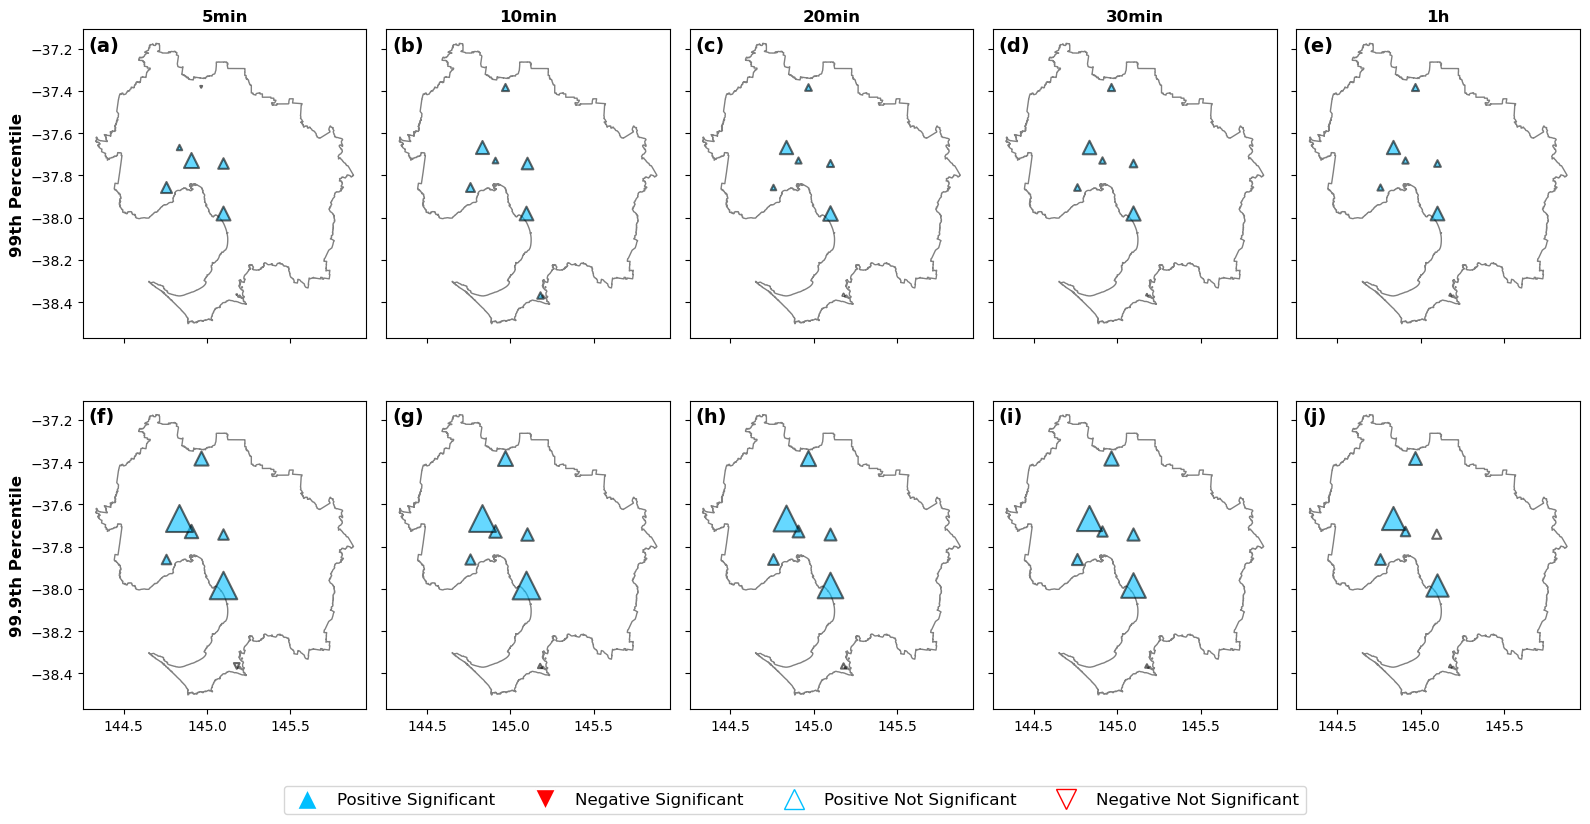

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import string
file_path = '/g/data/w28/yk8692/nesp/station_corrected_rv/'
# Load datasets
# data_99 = pd.read_csv(f'{file_path}p4_99perc_trend_P_rate.csv')
# data_999 = pd.read_csv(f'{file_path}p4_999perc_trend_P_rate.csv')

data_99 = pd.read_csv(f'{file_path}p4_99perc_trend_P_rate_excluding_zero_{region}.csv')
data_999 = pd.read_csv(f'{file_path}p4_999perc_trend_P_rate_excluding_zero_{region}.csv')

shape_path = '/g/data/w28/yk8692/nesp'
# Load the Greater Melbourne shapefile
gdf_shapefile= gpd.read_file(f"{shape_path}/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")

# Filter for the Greater Melbourne region
region = gdf_shapefile[gdf_shapefile['GCC_NAME21'] == 'Greater Melbourne']

# List of stations to highlight with black edges
highlight_stations = {'086038', '086068', '086077',
                      '086282', '086361', 
                      '087031', '088162'}

# Specify time intervals and datasets
time_intervals = ["5min", "10min", "20min", "30min", "1h"]
# datasets = [data_99, data_995, data_999]
datasets = [data_99, data_999]
# dataset_names = ["99th Percentile", "99.5th Percentile", "99.9th Percentile"]
dataset_names = ["99th Percentile", "99.9th Percentile"]

# Initialize subplots: 3 rows (percentiles) × 5 columns (time intervals)
fig, axes = plt.subplots(2, 5, figsize=(16, 8), sharex=True, sharey=True)

# Iterate over datasets (rows)
for row, (data, title) in enumerate(zip(datasets, dataset_names)):
    # Iterate over time intervals (columns)
    for col, interval in enumerate(time_intervals):
        ax = axes[row, col]
        # Filter data for the current interval
        subset = data[data["Interval"] == interval]

        # Only keep rows where the station (extracted from the "Station" column) is in highlight_stations.
        # Assumes the "Station" string is in the format "HD01D_Data_066037_..." and index 2 is the station number.
        subset = subset[subset["Station"].apply(lambda s: s.split("_")[2] in highlight_stations)]
        
        # Plot the Greater Sydney shapefile
        region.plot(ax=ax, color='white', edgecolor='grey', zorder=1)

        # Plot points based on slope and significance
        for _, row_data in subset.iterrows():
            # Extract station number from filename (assuming format like HD01D_Data_066037_...)
            station_num = row_data["Station"].split("_")[2]

            # Determine marker style and color based on significance and slope
            if row_data["Significance"] == "Significant":
                if row_data["Slope"] > 0:  # Positive significant
                    marker = "^"  # Upward triangle
                    facecolor = "deepskyblue"
                    edgecolor = "none"
                    marker_size = abs(row_data["Slope"]) * 10000000
                else:  # Negative significant
                    marker = "v"  # Downward triangle
                    facecolor = "red"
                    edgecolor = "none"
                    marker_size = abs(row_data["Slope"]) * 10000000
            else:  # Not significant
                if row_data["Slope"] > 0:  # Positive not significant
                    marker = "^"
                    facecolor = "none"
                    edgecolor = "deepskyblue"
                    marker_size = abs(row_data["Slope"]) * 10000000
                else:  # Negative not significant
                    marker = "v"
                    facecolor = "none"
                    edgecolor = "red"
                    marker_size = abs(row_data["Slope"]) * 10000000  

            # Check if the station needs a black edge
            if station_num in highlight_stations:
                edgecolor = "black"

            # Plot the point
            ax.scatter(
                row_data["Longitude"], row_data["Latitude"], 
                s=marker_size, c=facecolor, marker=marker, 
                edgecolor=edgecolor, linewidth=1.5, alpha=0.6, zorder=5
            )

        # Add titles for the columns (time intervals) on the top row
        if row == 0:
            ax.set_title(interval, fontsize=12, fontweight="bold")

        # Add labels for the rows (percentiles) on the first column
        if col == 0:
            ax.set_ylabel(title, fontsize=12, fontweight="bold")

        # Add subplot letter annotation (a), (b), (c), etc.
        # Compute the subplot index (0 to 14 for 3x5 subplots)
        subplot_index = row * len(time_intervals) + col  
        letter = string.ascii_lowercase[subplot_index]
        ax.text(0.02, 0.98, f'({letter})', transform=ax.transAxes,
                fontsize=14, fontweight='bold', va='top')

legend_elements = [
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="deepskyblue", markersize=15, label="Positive Significant"),
    plt.Line2D([0], [0], marker="v", color="w", markerfacecolor="red", markersize=15, label="Negative Significant"),
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="none", markeredgecolor="deepskyblue", markersize=15, label="Positive Not Significant"),
    plt.Line2D([0], [0], marker="v", color="w", markerfacecolor="none", markeredgecolor="red", markersize=15, label="Negative Not Significant"),
    # Optionally, add a marker for highlighted stations if needed:
    # plt.Line2D([0], [0], marker="o", color="black", markerfacecolor="none", markersize=15, label="Highlighted Stations"),
]

# Adjust layout
plt.tight_layout()

fig.legend(
    handles=legend_elements, 
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.01),  # Position below the subplots
    ncol=5,  # Number of columns in the legend
    fontsize=12
)

# Save the figure if needed
plt.savefig(f'{shape_path}/figure/trend_map_melbourne_99_999_with_sig_test_excluding_zero.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


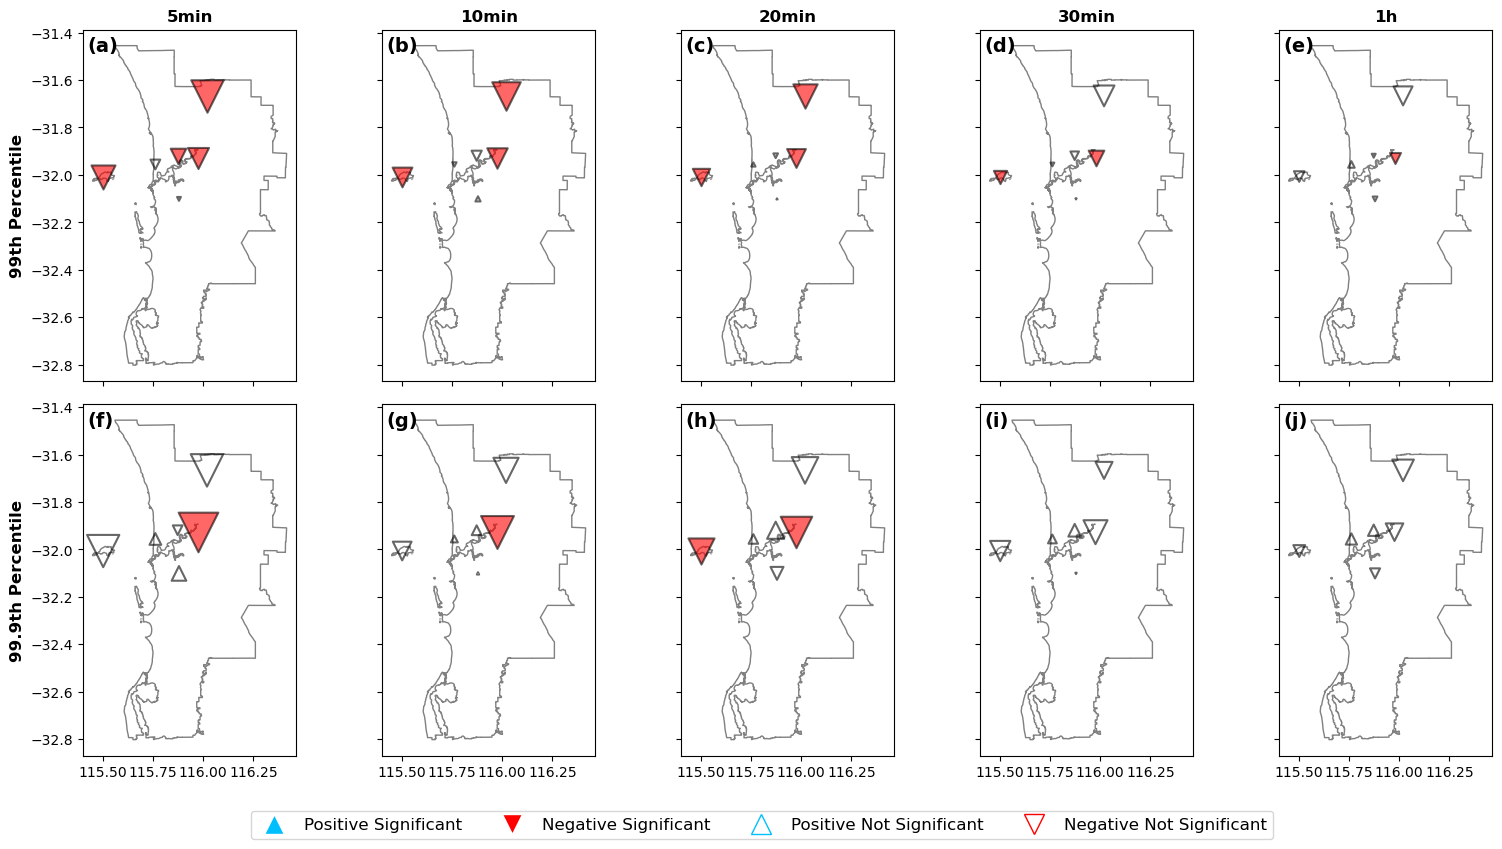

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import string
file_path = '/g/data/w28/yk8692/nesp/station_corrected_rv/'
# Load datasets
# data_99 = pd.read_csv(f'{file_path}p4_99perc_trend_P_rate.csv')
# data_999 = pd.read_csv(f'{file_path}p4_999perc_trend_P_rate.csv')

data_99 = pd.read_csv(f'{file_path}p4_99perc_trend_P_rate_excluding_zero_{region_name}.csv')
data_999 = pd.read_csv(f'{file_path}p4_999perc_trend_P_rate_excluding_zero_{region_name}.csv')

shape_path = '/g/data/w28/yk8692/nesp'
# Load the Greater Melbourne shapefile
gdf_shapefile= gpd.read_file(f"{shape_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")

# Filter for the Greater Melbourne region
region = gdf_shapefile[gdf_shapefile['GCC_NAME21'] == region_name_full]

# List of stations to highlight with black edges
highlight_stations = {
    '009193', '009172', '009225',
    '009021', '009053', '009215'
}
# Specify time intervals and datasets
time_intervals = ["5min", "10min", "20min", "30min", "1h"]
# datasets = [data_99, data_995, data_999]
datasets = [data_99, data_999]
# dataset_names = ["99th Percentile", "99.5th Percentile", "99.9th Percentile"]
dataset_names = ["99th Percentile", "99.9th Percentile"]

# Initialize subplots: 3 rows (percentiles) × 5 columns (time intervals)
fig, axes = plt.subplots(2, 5, figsize=(16, 8), sharex=True, sharey=True)

# Iterate over datasets (rows)
for row, (data, title) in enumerate(zip(datasets, dataset_names)):
    # Iterate over time intervals (columns)
    for col, interval in enumerate(time_intervals):
        ax = axes[row, col]
        # Filter data for the current interval
        subset = data[data["Interval"] == interval]

        # Only keep rows where the station (extracted from the "Station" column) is in highlight_stations.
        # Assumes the "Station" string is in the format "HD01D_Data_066037_..." and index 2 is the station number.
        subset = subset[subset["Station"].apply(lambda s: s.split("_")[2] in highlight_stations)]
        
        # Plot the Greater Sydney shapefile
        region.plot(ax=ax, color='white', edgecolor='grey', zorder=1)

        # Plot points based on slope and significance
        for _, row_data in subset.iterrows():
            # Extract station number from filename (assuming format like HD01D_Data_066037_...)
            station_num = row_data["Station"].split("_")[2]

            # Determine marker style and color based on significance and slope
            if row_data["Significance"] == "Significant":
                if row_data["Slope"] > 0:  # Positive significant
                    marker = "^"  # Upward triangle
                    facecolor = "deepskyblue"
                    edgecolor = "none"
                    marker_size = abs(row_data["Slope"]) * 10000000
                else:  # Negative significant
                    marker = "v"  # Downward triangle
                    facecolor = "red"
                    edgecolor = "none"
                    marker_size = abs(row_data["Slope"]) * 10000000
            else:  # Not significant
                if row_data["Slope"] > 0:  # Positive not significant
                    marker = "^"
                    facecolor = "none"
                    edgecolor = "deepskyblue"
                    marker_size = abs(row_data["Slope"]) * 10000000
                else:  # Negative not significant
                    marker = "v"
                    facecolor = "none"
                    edgecolor = "red"
                    marker_size = abs(row_data["Slope"]) * 10000000  

            # Check if the station needs a black edge
            if station_num in highlight_stations:
                edgecolor = "black"

            # Plot the point
            ax.scatter(
                row_data["Longitude"], row_data["Latitude"], 
                s=marker_size, c=facecolor, marker=marker, 
                edgecolor=edgecolor, linewidth=1.5, alpha=0.6, zorder=5
            )

        # Add titles for the columns (time intervals) on the top row
        if row == 0:
            ax.set_title(interval, fontsize=12, fontweight="bold")

        # Add labels for the rows (percentiles) on the first column
        if col == 0:
            ax.set_ylabel(title, fontsize=12, fontweight="bold")

        # Add subplot letter annotation (a), (b), (c), etc.
        # Compute the subplot index (0 to 14 for 3x5 subplots)
        subplot_index = row * len(time_intervals) + col  
        letter = string.ascii_lowercase[subplot_index]
        ax.text(0.02, 0.98, f'({letter})', transform=ax.transAxes,
                fontsize=14, fontweight='bold', va='top')

legend_elements = [
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="deepskyblue", markersize=15, label="Positive Significant"),
    plt.Line2D([0], [0], marker="v", color="w", markerfacecolor="red", markersize=15, label="Negative Significant"),
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="none", markeredgecolor="deepskyblue", markersize=15, label="Positive Not Significant"),
    plt.Line2D([0], [0], marker="v", color="w", markerfacecolor="none", markeredgecolor="red", markersize=15, label="Negative Not Significant"),
    # Optionally, add a marker for highlighted stations if needed:
    # plt.Line2D([0], [0], marker="o", color="black", markerfacecolor="none", markersize=15, label="Highlighted Stations"),
]

# Adjust layout
plt.tight_layout()

fig.legend(
    handles=legend_elements, 
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.01),  # Position below the subplots
    ncol=5,  # Number of columns in the legend
    fontsize=12
)

# Save the figure if needed
plt.savefig(f'{shape_path}/figure/trend_map_{region_name}_99_999_with_sig_test_excluding_zero.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


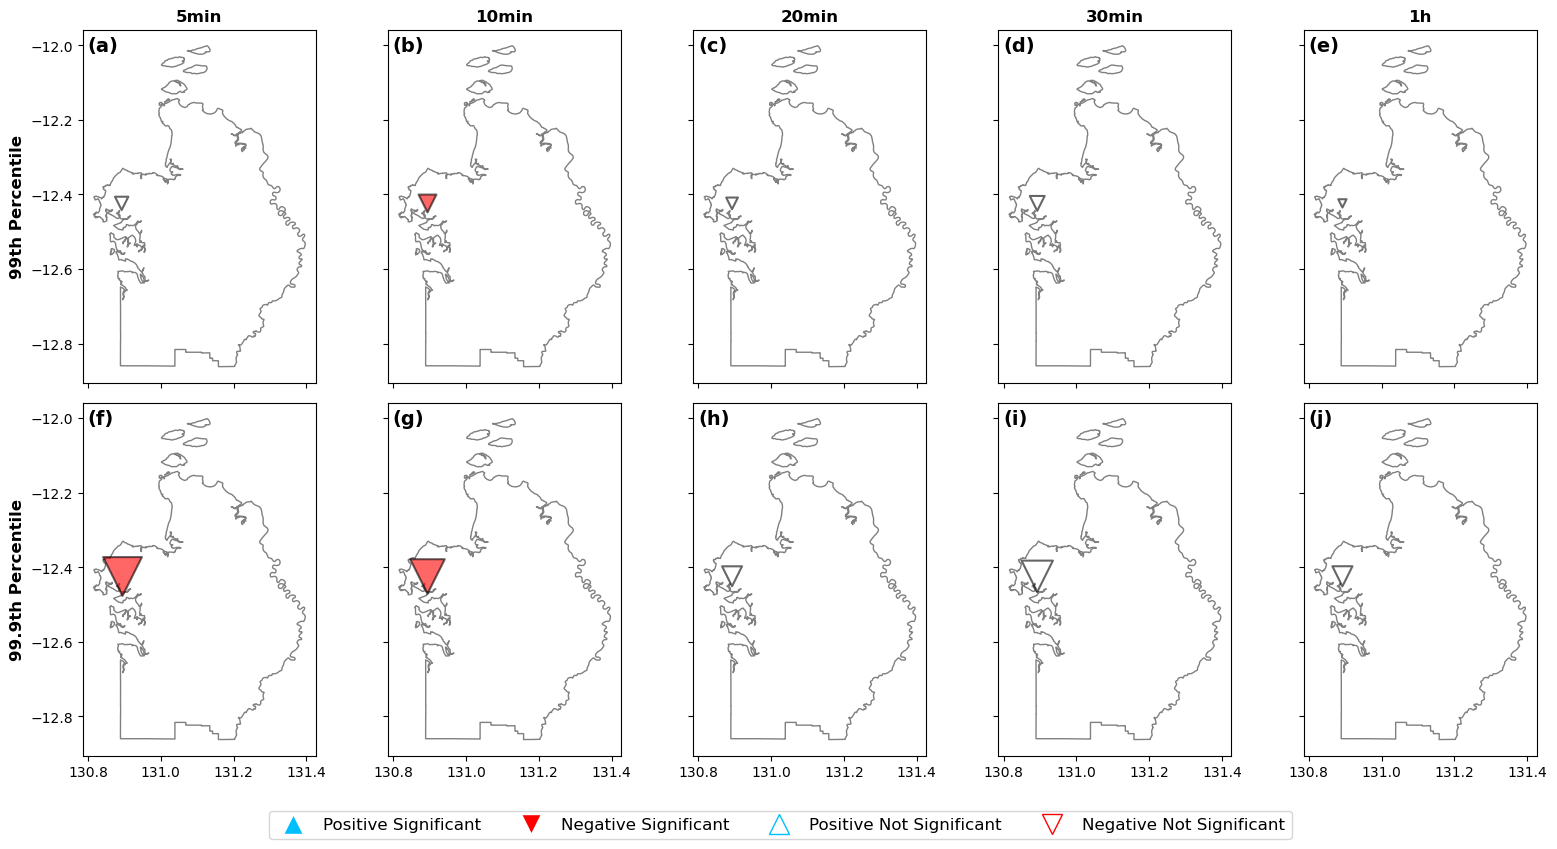

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import string
file_path = '/g/data/w28/yk8692/nesp_backup/station_corrected_rv/'
# Load datasets
# data_99 = pd.read_csv(f'{file_path}p4_99perc_trend_P_rate.csv')
# data_999 = pd.read_csv(f'{file_path}p4_999perc_trend_P_rate.csv')

data_99 = pd.read_csv(f'{file_path}p4_99perc_trend_P_rate_excluding_zero_{region_name}.csv')
data_999 = pd.read_csv(f'{file_path}p4_999perc_trend_P_rate_excluding_zero_{region_name}.csv')

shape_path = '/g/data/w28/yk8692/nesp_backup'
# Load the Greater Melbourne shapefile
gdf_shapefile= gpd.read_file(f"{shape_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp")

# Filter for the Greater Melbourne region
region = gdf_shapefile[gdf_shapefile['GCC_NAME21'] == region_name_full]

# List of stations to highlight with black edges
# highlight_stations = {
#     '040004', '040043', '040211',
#     '040842', '040913', '040958'

# highlight_stations = {
#     '023885', '023090', '023083',
#     '023034', '023013'
# }
# highlight_stations = {
#     '094087', '094029', '094008',
# }
# highlight_stations = {
#     '070339',
# }
highlight_stations = {
    '014015',
}
# Specify time intervals and datasets
time_intervals = ["5min", "10min", "20min", "30min", "1h"]
# datasets = [data_99, data_995, data_999]
datasets = [data_99, data_999]
# dataset_names = ["99th Percentile", "99.5th Percentile", "99.9th Percentile"]
dataset_names = ["99th Percentile", "99.9th Percentile"]

# Initialize subplots: 3 rows (percentiles) × 5 columns (time intervals)
fig, axes = plt.subplots(2, 5, figsize=(16, 8), sharex=True, sharey=True)

# Iterate over datasets (rows)
for row, (data, title) in enumerate(zip(datasets, dataset_names)):
    # Iterate over time intervals (columns)
    for col, interval in enumerate(time_intervals):
        ax = axes[row, col]
        # Filter data for the current interval
        subset = data[data["Interval"] == interval]

        # Only keep rows where the station (extracted from the "Station" column) is in highlight_stations.
        # Assumes the "Station" string is in the format "HD01D_Data_066037_..." and index 2 is the station number.
        subset = subset[subset["Station"].apply(lambda s: s.split("_")[2] in highlight_stations)]
        
        # Plot the Greater Sydney shapefile
        region.plot(ax=ax, color='white', edgecolor='grey', zorder=1)

        # Plot points based on slope and significance
        for _, row_data in subset.iterrows():
            # Extract station number from filename (assuming format like HD01D_Data_066037_...)
            station_num = row_data["Station"].split("_")[2]

            # Determine marker style and color based on significance and slope
            if row_data["Significance"] == "Significant":
                if row_data["Slope"] > 0:  # Positive significant
                    marker = "^"  # Upward triangle
                    facecolor = "deepskyblue"
                    edgecolor = "none"
                    marker_size = abs(row_data["Slope"]) * 10000000
                else:  # Negative significant
                    marker = "v"  # Downward triangle
                    facecolor = "red"
                    edgecolor = "none"
                    marker_size = abs(row_data["Slope"]) * 10000000
            else:  # Not significant
                if row_data["Slope"] > 0:  # Positive not significant
                    marker = "^"
                    facecolor = "none"
                    edgecolor = "deepskyblue"
                    marker_size = abs(row_data["Slope"]) * 10000000
                else:  # Negative not significant
                    marker = "v"
                    facecolor = "none"
                    edgecolor = "red"
                    marker_size = abs(row_data["Slope"]) * 10000000  

            # Check if the station needs a black edge
            if station_num in highlight_stations:
                edgecolor = "black"

            # Plot the point
            ax.scatter(
                row_data["Longitude"], row_data["Latitude"], 
                s=marker_size, c=facecolor, marker=marker, 
                edgecolor=edgecolor, linewidth=1.5, alpha=0.6, zorder=5
            )

        # Add titles for the columns (time intervals) on the top row
        if row == 0:
            ax.set_title(interval, fontsize=12, fontweight="bold")

        # Add labels for the rows (percentiles) on the first column
        if col == 0:
            ax.set_ylabel(title, fontsize=12, fontweight="bold")

        # Add subplot letter annotation (a), (b), (c), etc.
        # Compute the subplot index (0 to 14 for 3x5 subplots)
        subplot_index = row * len(time_intervals) + col  
        letter = string.ascii_lowercase[subplot_index]
        ax.text(0.02, 0.98, f'({letter})', transform=ax.transAxes,
                fontsize=14, fontweight='bold', va='top')

legend_elements = [
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="deepskyblue", markersize=15, label="Positive Significant"),
    plt.Line2D([0], [0], marker="v", color="w", markerfacecolor="red", markersize=15, label="Negative Significant"),
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="none", markeredgecolor="deepskyblue", markersize=15, label="Positive Not Significant"),
    plt.Line2D([0], [0], marker="v", color="w", markerfacecolor="none", markeredgecolor="red", markersize=15, label="Negative Not Significant"),
    # Optionally, add a marker for highlighted stations if needed:
    # plt.Line2D([0], [0], marker="o", color="black", markerfacecolor="none", markersize=15, label="Highlighted Stations"),
]

# Adjust layout
plt.tight_layout()

fig.legend(
    handles=legend_elements, 
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.01),  # Position below the subplots
    ncol=5,  # Number of columns in the legend
    fontsize=12
)

# Save the figure if needed
plt.savefig(f'{shape_path}/figure/trend_map_{region_name}_99_999_with_sig_test_excluding_zero.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()
